In [1]:
!pip install networkx
!pip install python-louvain
!pip install matplotlib


In [29]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
from networkx.algorithms.community import girvan_newman
from datetime import datetime
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dissertation/CollegeMsg.txt', sep=" ", header=None, names=["sender", "receiver", "timestamp"])
# Update the file route accordingly

# Convert 'timestamp' to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sender,receiver,timestamp
0,1,2,2004-04-15 14:56:01
1,3,4,2004-04-16 22:50:39
2,5,2,2004-04-19 22:39:51
3,6,7,2004-04-20 05:40:19
4,8,7,2004-04-20 05:42:36


**Static Network Analysis**

In [4]:
# Create a directed graph from the data
G = nx.DiGraph()

# Add edges from the dataset to the graph
for index, row in data.iterrows():
    G.add_edge(row['sender'], row['receiver'], timestamp=row['timestamp'])

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 1899
Number of edges: 20296


In [44]:
# Calculate node degrees
degrees = dict(G.degree())

# Define a threshold for high-degree nodes (e.g., top 2% of nodes by degree)
degree_threshold = pd.Series(degrees).quantile(0.98)

# Create a subgraph containing only high-degree nodes
high_degree_nodes = [node for node, degree in degrees.items() if degree >= degree_threshold]
G_filtered = G.subgraph(high_degree_nodes)

print(f"Filtered number of nodes: {G_filtered.number_of_nodes()}")
print(f"Filtered number of edges: {G_filtered.number_of_edges()}")

Filtered number of nodes: 38
Filtered number of edges: 401


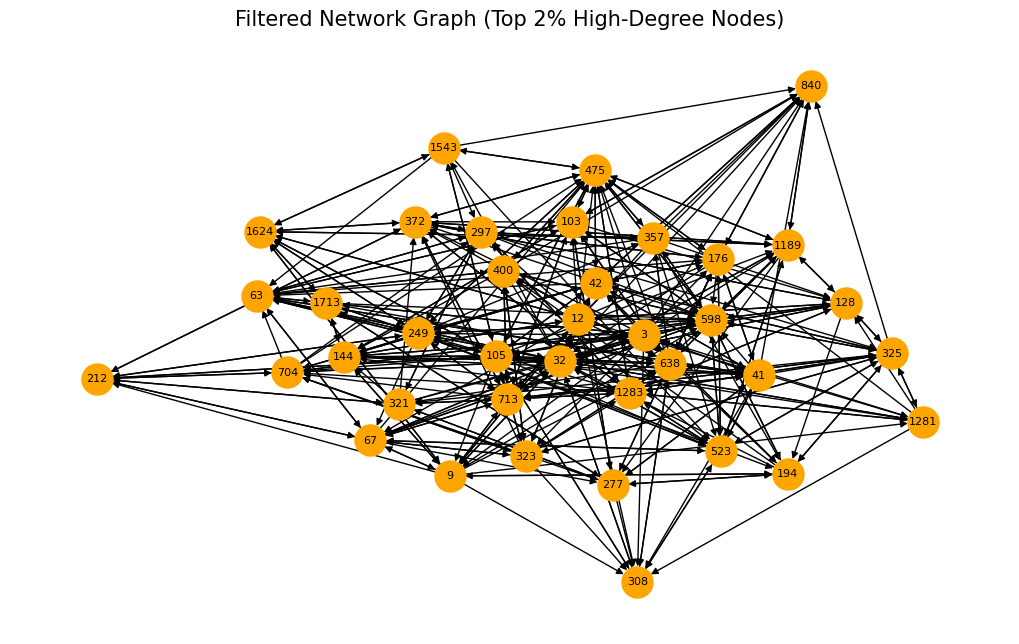

In [45]:
# Set figure size
plt.figure(figsize=(10, 6))

# Draw the network
pos = nx.spring_layout(G_filtered, seed=42)
nx.draw(G_filtered, pos, with_labels=True, node_color='orange', node_size=500, edge_color='black', font_size=8)

# Display the plot
plt.title("Filtered Network Graph (Top 2% High-Degree Nodes)", size=15)
plt.show()

In [9]:
# Convert the full directed graph to an undirected graph for community detection
undirected_G = G.to_undirected()

# Apply Louvain community detection
partition = community_louvain.best_partition(undirected_G)

# Add the community information as a node attribute
nx.set_node_attributes(G, partition, 'community')

# Display the detected communities
communities = set(partition.values())
print(f"Number of communities detected in the full graph: {len(communities)}")

# Count the size of each community
community_sizes = Counter(partition.values())

# Display the largest communities
print("Largest communities by size:")
for community_id, size in community_sizes.most_common(len(communities)):
    print(f"Community {community_id}: {size} nodes")

# Calculate modularity score for the partition
modularity_score = community_louvain.modularity(partition, undirected_G)
print(f"Modularity Score: {modularity_score}")

Number of communities detected in the full graph: 16
Largest communities by size:
Community 2: 323 nodes
Community 6: 273 nodes
Community 7: 241 nodes
Community 12: 204 nodes
Community 1: 146 nodes
Community 14: 118 nodes
Community 11: 112 nodes
Community 13: 101 nodes
Community 8: 97 nodes
Community 3: 90 nodes
Community 5: 83 nodes
Community 0: 74 nodes
Community 10: 31 nodes
Community 9: 2 nodes
Community 4: 2 nodes
Community 15: 2 nodes
Modularity Score: 0.24516327578547548


In [10]:
# Calculate node degrees
degrees = dict(G.degree())

# Calculate betweenness centrality
betweenness = nx.betweenness_centrality(G)

# Calculate clustering coefficient
clustering = nx.clustering(undirected_G)

# Combine into a DataFrame for easier analysis
node_metrics = pd.DataFrame({
    'Degree': pd.Series(degrees),
    'BetweennessCentrality': pd.Series(betweenness),
    'ClusteringCoefficient': pd.Series(clustering),
    'Community': pd.Series(partition)
})

print(node_metrics)


      Degree  BetweennessCentrality  ClusteringCoefficient  Community
1         58               0.004209               0.099160          0
2          5               0.000000               0.200000          0
3        216               0.016287               0.049007          0
4          1               0.000000               0.000000          0
5          1               0.000000               0.000000          0
...      ...                    ...                    ...        ...
1895       1               0.000000               0.000000          6
1896       1               0.000000               0.000000          2
1897       2               0.000000               0.000000          7
1898       2               0.000000               0.000000          8
1899      26               0.000000               0.009231         13

[1899 rows x 4 columns]


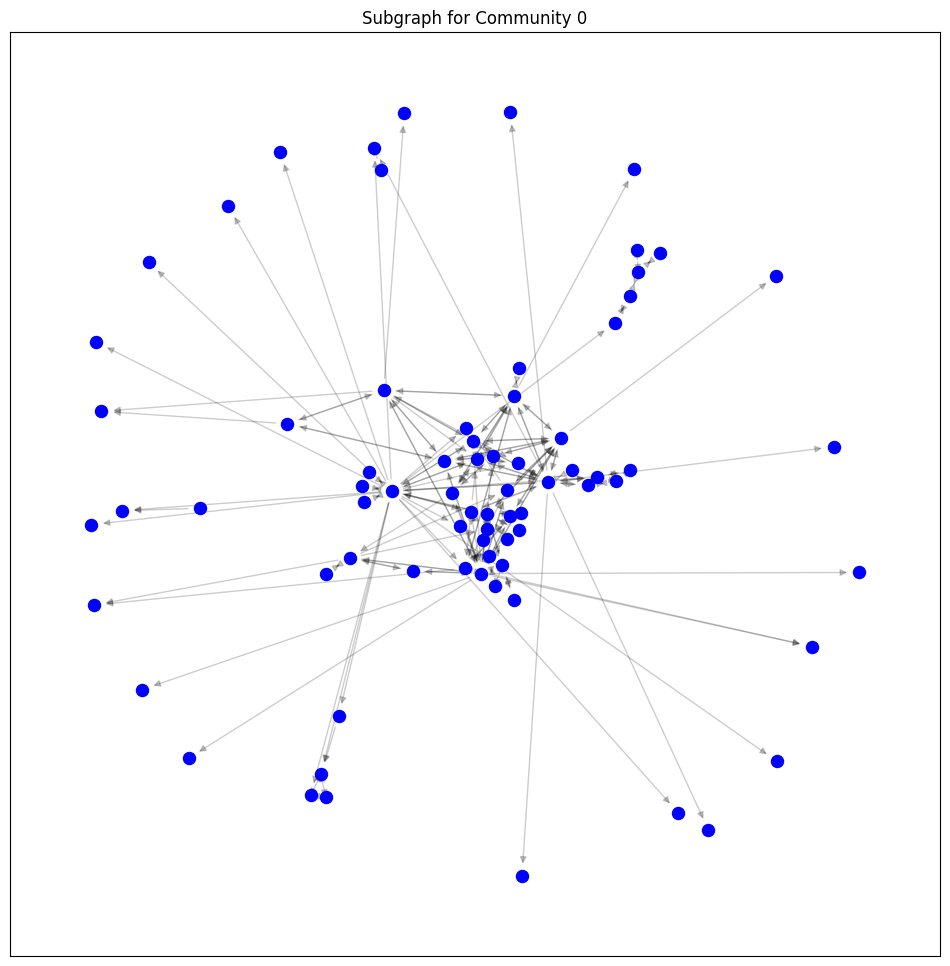

In [13]:
# Filter graph for a single community (e.g., community 0)
community_0_nodes = [node for node, comm in partition.items() if comm == 0]
G_community_0 = G.subgraph(community_0_nodes)

# Visualise the subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_community_0)
nx.draw_networkx_nodes(G_community_0, pos, node_size=75, node_color='blue')
nx.draw_networkx_edges(G_community_0, pos, alpha=0.2)
plt.title("Subgraph for Community 0")
plt.show()

In [14]:
# Calculate node degrees
degrees = dict(G.degree())

# Define a threshold for high-degree nodes (e.g., top 10% of nodes by degree)
degree_threshold = pd.Series(degrees).quantile(0.9)

# Create a subgraph containing only high-degree nodes
high_degree_nodes = [node for node, degree in degrees.items() if degree >= degree_threshold]
G_filtered = G.subgraph(high_degree_nodes)

print(f"Filtered number of nodes: {G_filtered.number_of_nodes()}")
print(f"Filtered number of edges: {G_filtered.number_of_edges()}")

Filtered number of nodes: 192
Filtered number of edges: 4447


In [15]:
# Convert the filtered directed graph to an undirected graph for community detection
undirected_G_filtered = G_filtered.to_undirected()

# Apply Louvain community detection on the filtered graph
partition_filtered = community_louvain.best_partition(undirected_G_filtered)

# Add the community information as a node attribute
nx.set_node_attributes(G_filtered, partition_filtered, 'community')

# Display the detected communities
communities = set(partition_filtered.values())
print(f"Number of communities detected in filtered graph: {len(communities)}")

Number of communities detected in filtered graph: 5


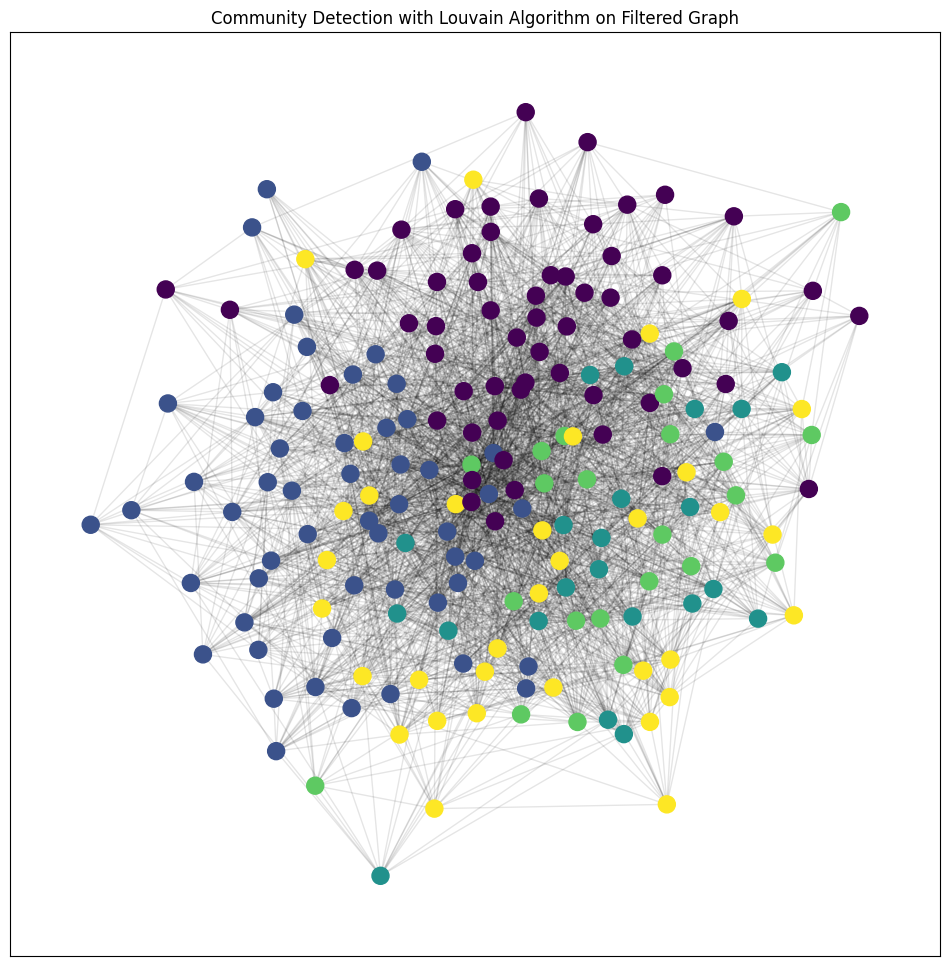

In [16]:
# Set color for each community
pos = nx.spring_layout(undirected_G_filtered, seed=42)  # Positioning the graph for better visualisation

plt.figure(figsize=(12, 12))
cmap = plt.get_cmap('viridis', max(partition_filtered.values()) + 1)
nx.draw_networkx_nodes(undirected_G_filtered, pos, partition_filtered.keys(), node_size=150, cmap=cmap, node_color=list(partition_filtered.values()))
nx.draw_networkx_edges(undirected_G_filtered, pos, alpha=0.1)
plt.title("Community Detection with Louvain Algorithm on Filtered Graph")
plt.show()

In [21]:
# Define a weight threshold (e.g., only keep edges with weight above 1)
weight_threshold = 1
G_filtered = nx.DiGraph()

# Add only edges with weight above the threshold
for index, row in edge_weights.iterrows():
    if row['weight'] > weight_threshold:
        G_filtered.add_edge(row['sender'], row['receiver'], weight=row['weight'])

# Convert to an undirected graph for community detection
undirected_G_filtered = G_filtered.to_undirected()

# Apply Louvain community detection on the filtered graph
partition_filtered = community_louvain.best_partition(undirected_G_filtered, weight='weight')

# Calculate modularity score for the filtered partition
modularity_score_filtered = community_louvain.modularity(partition_filtered, undirected_G_filtered)
print(f"Modularity Score after Filtering: {modularity_score_filtered}")

Modularity Score after Filtering: 0.38021449321339806


In [23]:
# Calculate the size of each community
community_sizes = Counter(partition_filtered.values())

# Display the largest communities and their sizes
print("Largest communities by size after filtering:")
for community_id, size in community_sizes.most_common(10):
    print(f"Community {community_id}: {size} nodes")

# Create a DataFrame to analyze node-level metrics within communities
node_metrics = pd.DataFrame({
    'Node': list(partition_filtered.keys()),
    'Community': list(partition_filtered.values()),
})

# Calculate node degrees (number of connections each node has)
node_metrics['Degree'] = node_metrics['Node'].map(dict(G.degree()))

# Calculate betweenness centrality (a measure of node influence)
betweenness_centrality = nx.betweenness_centrality(G)
node_metrics['BetweennessCentrality'] = node_metrics['Node'].map(betweenness_centrality)

# Display the top 10 nodes by betweenness centrality within each community
print("Top nodes by betweenness centrality in each community:")
for community_id in community_sizes:
    top_nodes = node_metrics[node_metrics['Community'] == community_id].sort_values(by='BetweennessCentrality', ascending=False).head(10)
    print(f"\nCommunity {community_id} (Size: {community_sizes[community_id]}):")
    print(top_nodes[['Node', 'Degree', 'BetweennessCentrality']])


Largest communities by size after filtering:
Community 13: 194 nodes
Community 7: 163 nodes
Community 10: 126 nodes
Community 3: 122 nodes
Community 17: 113 nodes
Community 1: 106 nodes
Community 0: 104 nodes
Community 2: 91 nodes
Community 18: 82 nodes
Community 12: 75 nodes
Top nodes by betweenness centrality in each community:

Community 0 (Size: 104):
     Node  Degree  BetweennessCentrality
1       3     216               0.016287
183  1281     164               0.011798
29     72     134               0.010713
154   679     130               0.009086
182  1280      90               0.004253
0       1      58               0.004209
338   474      94               0.004199
394  1033      76               0.003698
534   393      84               0.003607
591  1253      67               0.002618

Community 1 (Size: 106):
     Node  Degree  BetweennessCentrality
217   103     339               0.029845
344   704     157               0.010923
157   697     129               0.008728
4

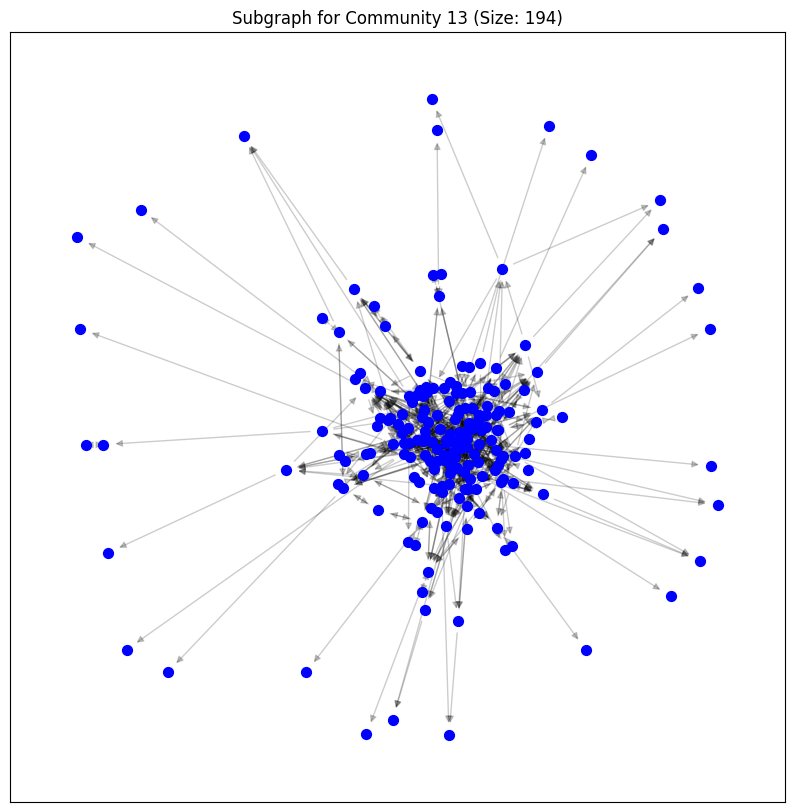

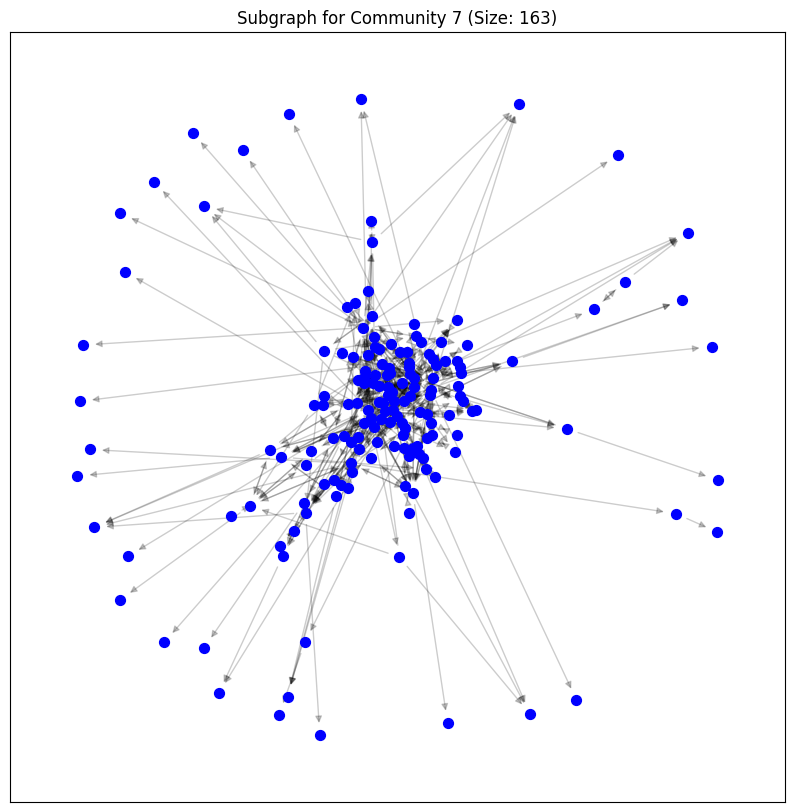

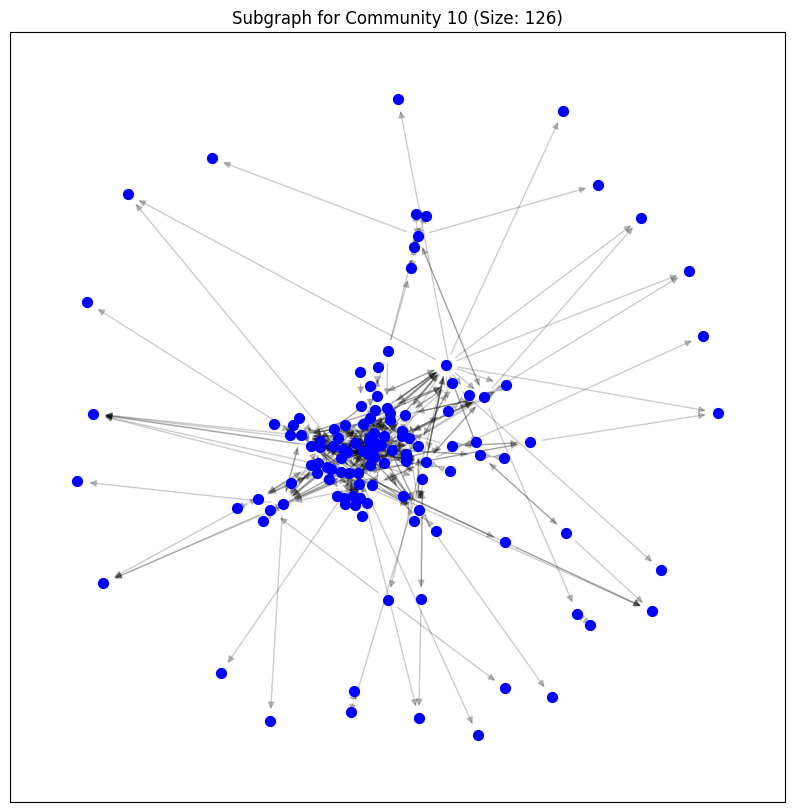

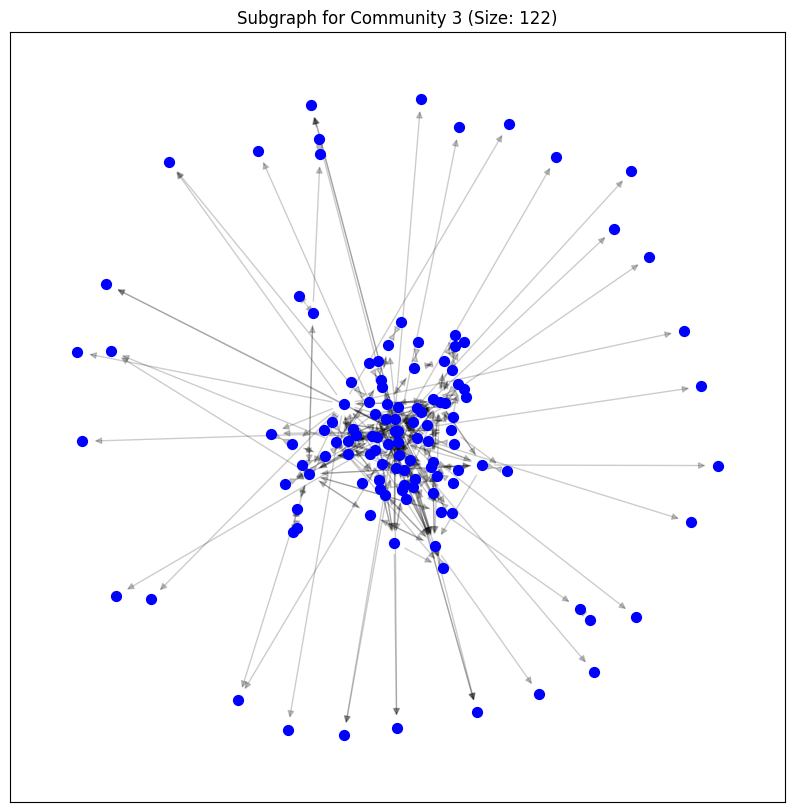

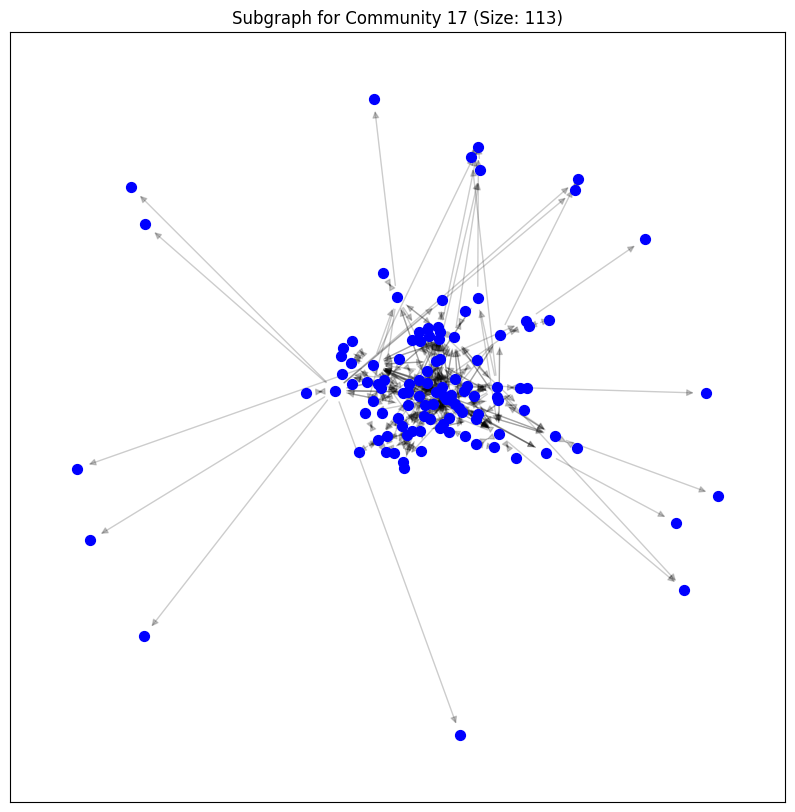

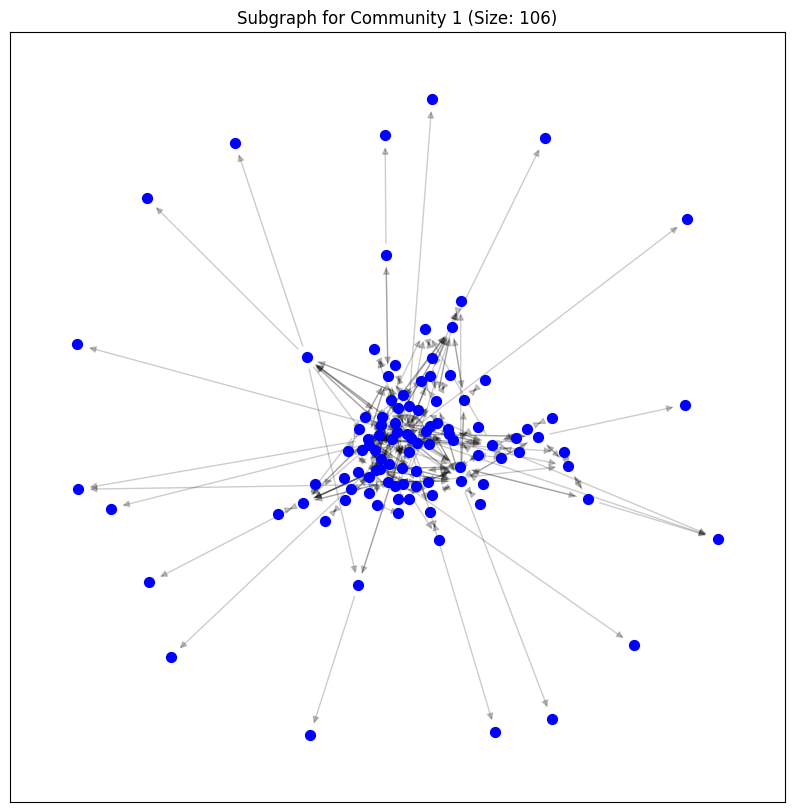

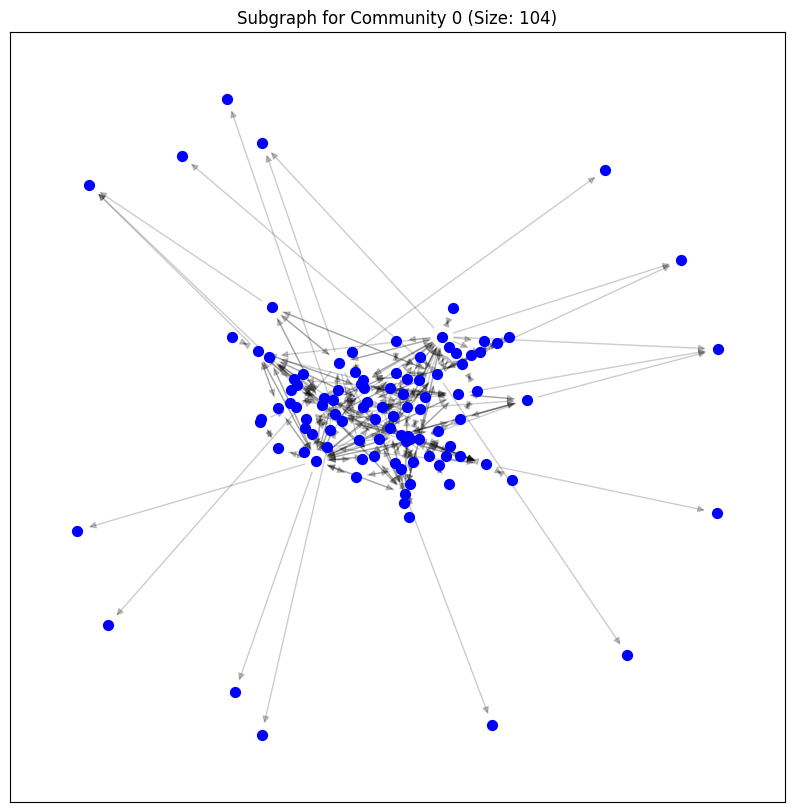

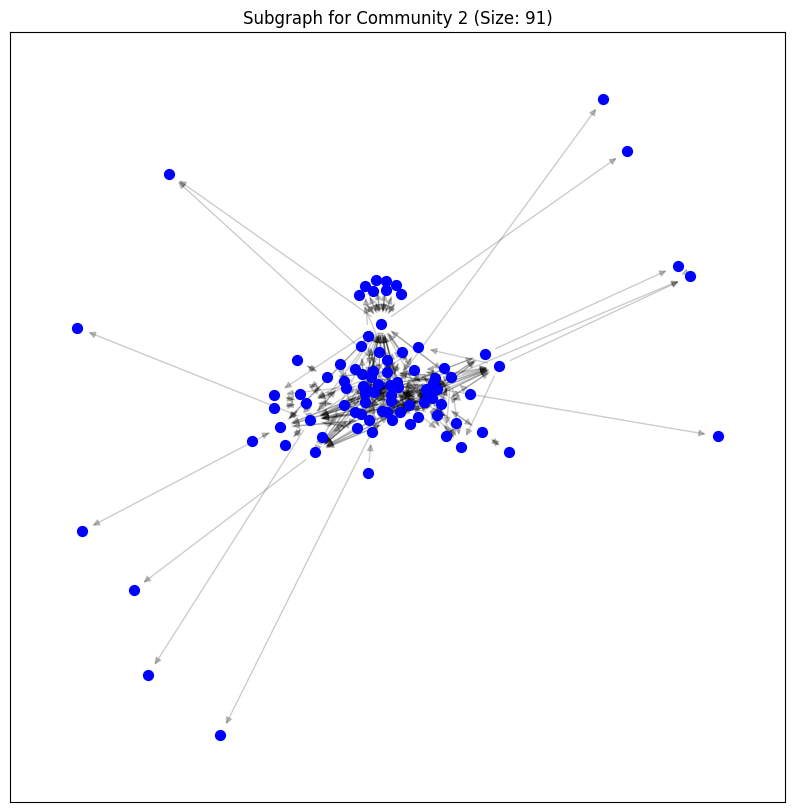

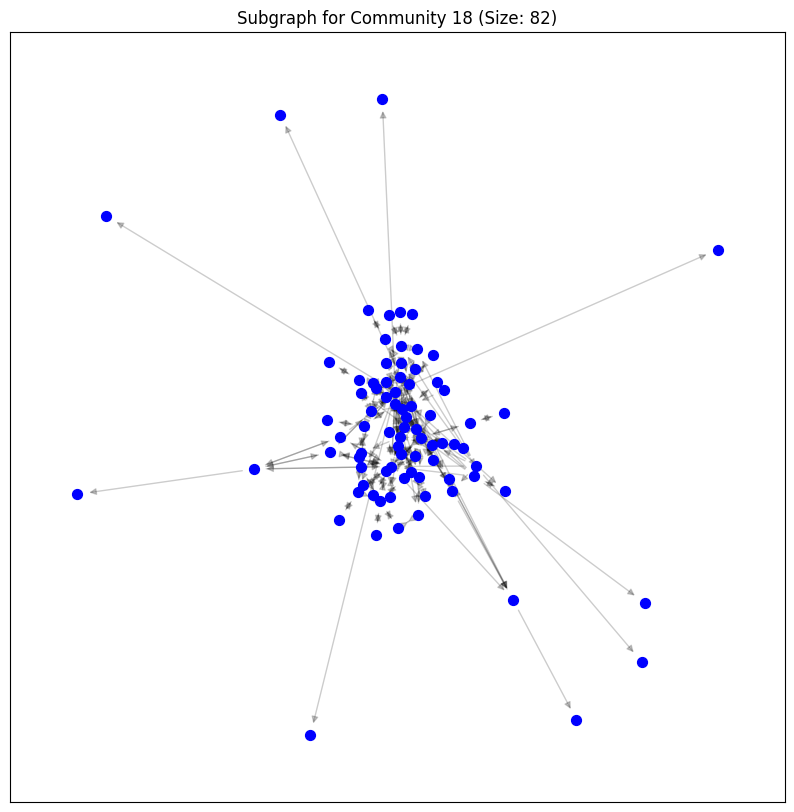

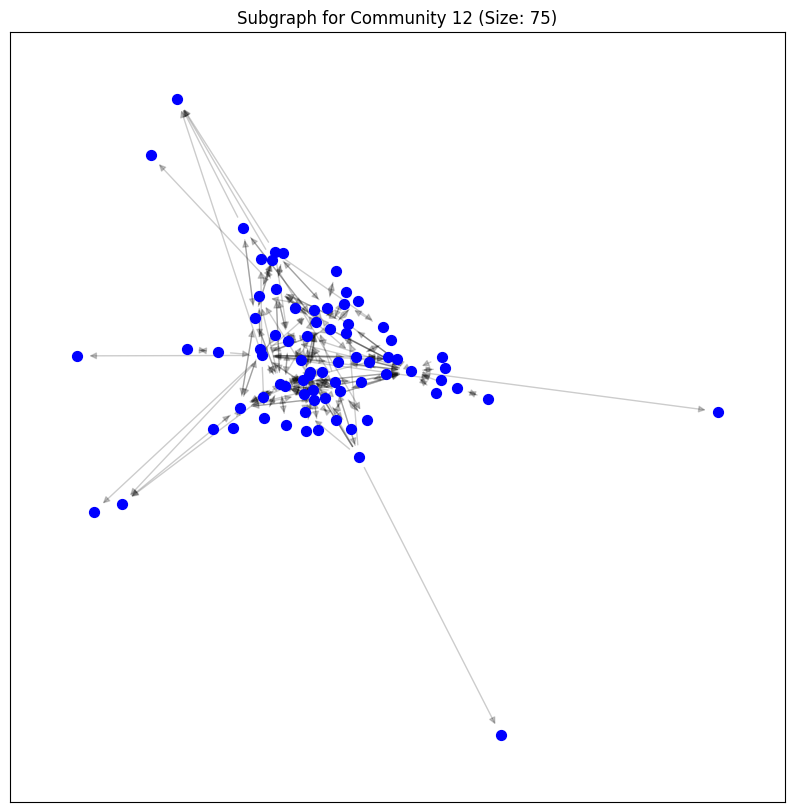

In [24]:
# Visualise subgraphs for the largest communities
for community_id, size in community_sizes.most_common(10):  # Adjust the number to visualise more or fewer communities
    community_nodes = [node for node, comm in partition_filtered.items() if comm == community_id]
    G_community = G.subgraph(community_nodes)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G_community, seed=42)  # Layout for better visualisation
    nx.draw_networkx_nodes(G_community, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(G_community, pos, alpha=0.2)
    plt.title(f"Subgraph for Community {community_id} (Size: {size})")
    plt.show()

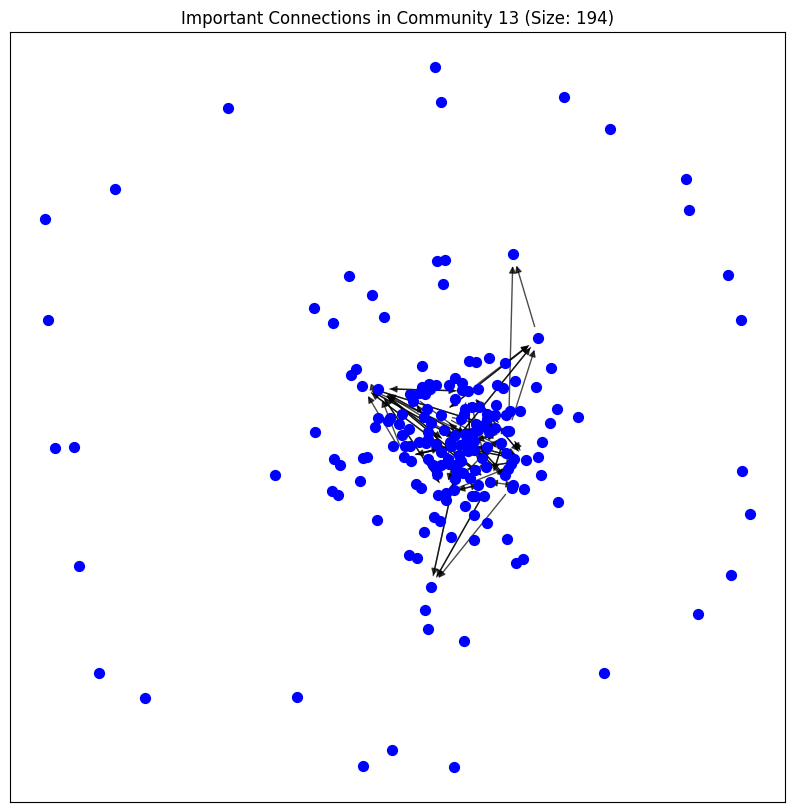

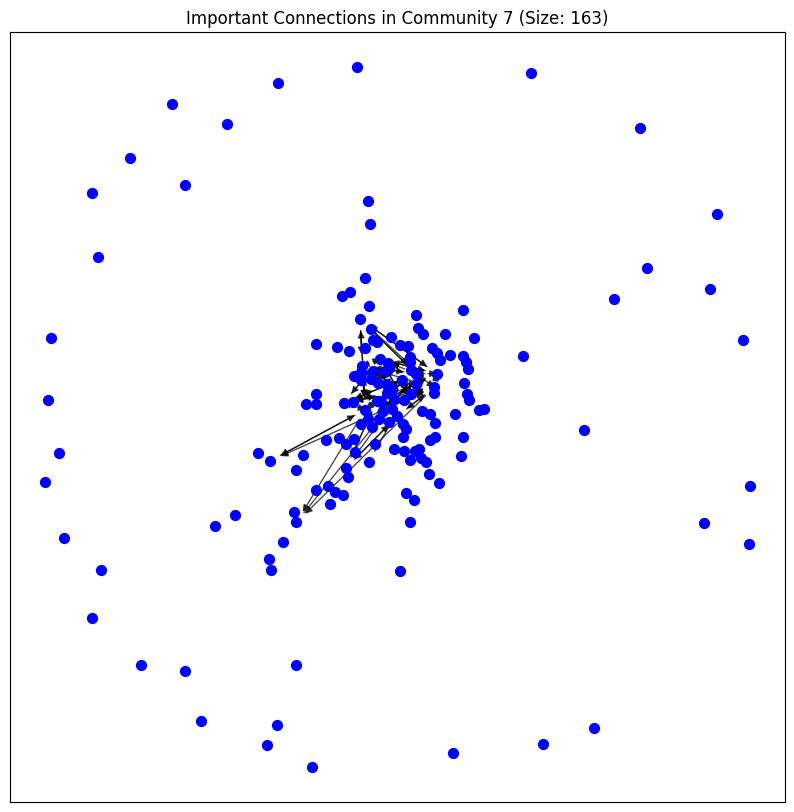

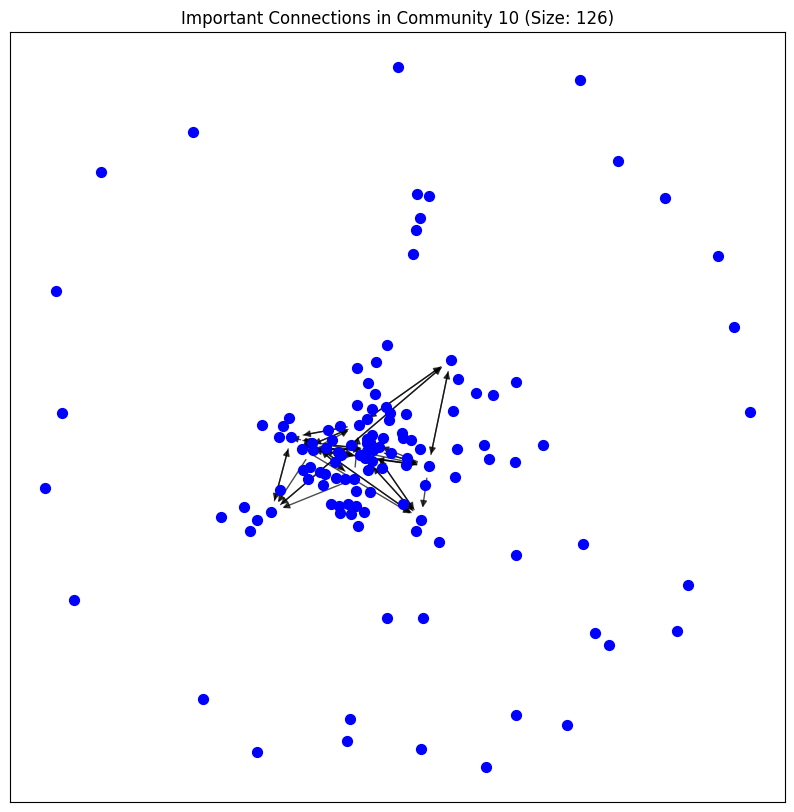

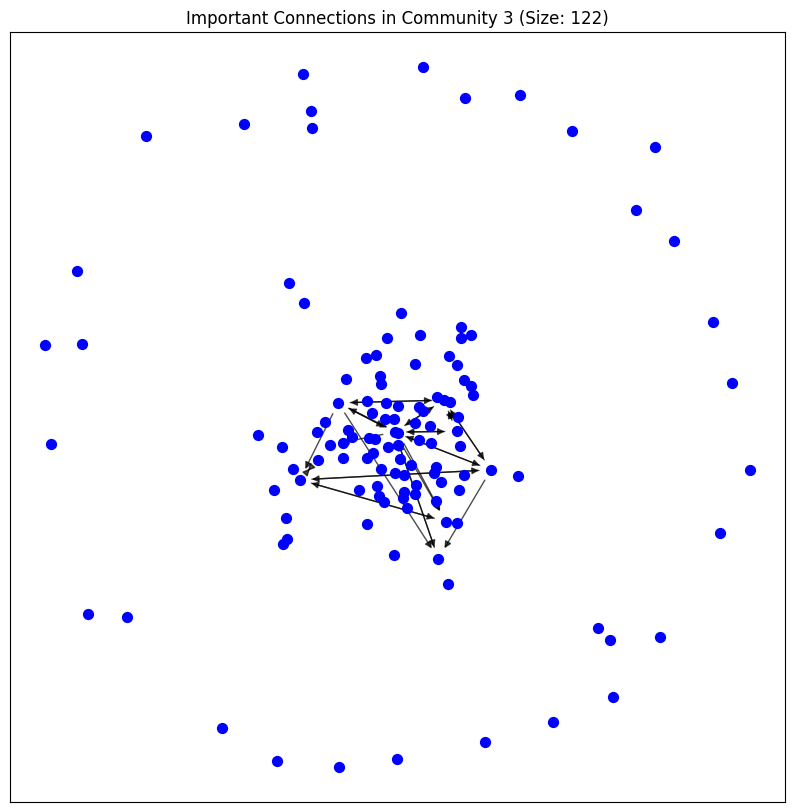

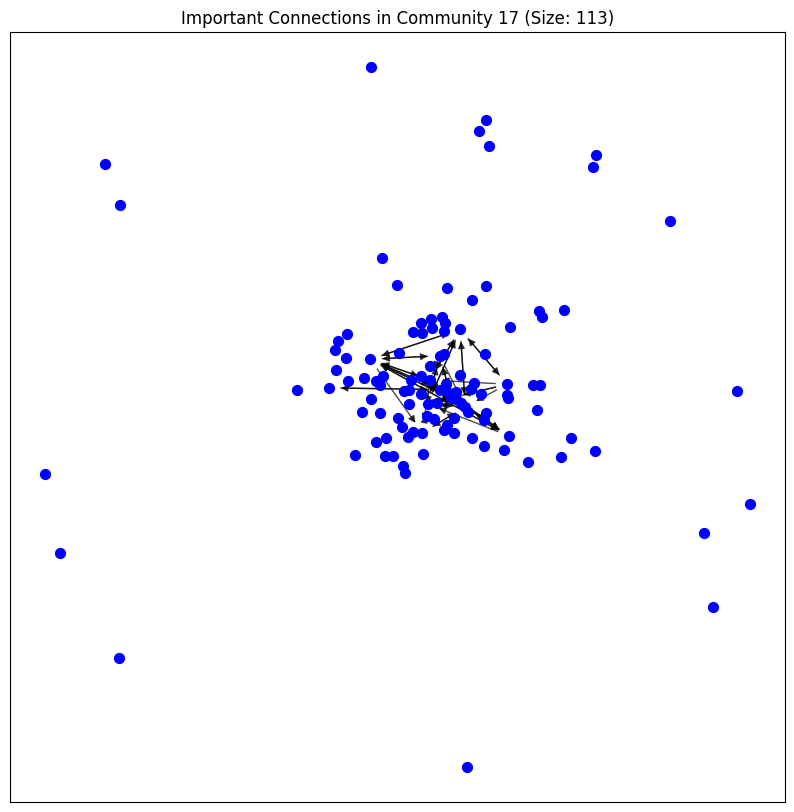

In [25]:
# Visualise only the most important connections within a community
for community_id, size in community_sizes.most_common(5):
    community_nodes = [node for node, comm in partition_filtered.items() if comm == community_id]
    G_community = G.subgraph(community_nodes)

    # Calculate the top 10% of edges by weight (or degree) to visualise
    threshold = pd.Series([G.degree(node) for node in community_nodes]).quantile(0.9)
    important_edges = [(u, v) for u, v in G_community.edges if G.degree(u) >= threshold and G.degree(v) >= threshold]

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G_community, seed=42)
    nx.draw_networkx_nodes(G_community, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(G_community, pos, edgelist=important_edges, alpha=0.7, edge_color='black')
    plt.title(f"Important Connections in Community {community_id} (Size: {size})")
    plt.show()

In [26]:
# Experiment with different thresholds
for weight_threshold in [1, 2, 5,7,10,9,11,13,15,17]:  # Adjust as needed for your data
    G_weighted_filtered = nx.DiGraph()
    for index, row in edge_weights.iterrows():
        if row['weight'] > weight_threshold:
            G_weighted_filtered.add_edge(row['sender'], row['receiver'], weight=row['weight'])

    undirected_G_weighted_filtered = G_weighted_filtered.to_undirected()
    partition_optimized = community_louvain.best_partition(undirected_G_weighted_filtered, weight='weight')
    modularity_score_optimized = community_louvain.modularity(partition_optimized, undirected_G_weighted_filtered)
    print(f"Modularity Score with weight threshold {weight_threshold}: {modularity_score_optimized}")

Modularity Score with weight threshold 1: 0.38132628844934674
Modularity Score with weight threshold 2: 0.42805091517506993
Modularity Score with weight threshold 5: 0.5452346684932745
Modularity Score with weight threshold 7: 0.602651707808909
Modularity Score with weight threshold 10: 0.6857903525270062
Modularity Score with weight threshold 9: 0.6532207675231558
Modularity Score with weight threshold 11: 0.7145474383892634
Modularity Score with weight threshold 13: 0.7554174258017647
Modularity Score with weight threshold 15: 0.7865060257031188
Modularity Score with weight threshold 17: 0.807902326863018


In [27]:
# Analyze the community structure at weight threshold 17
weight_threshold_optimal = 17
G_optimized = nx.DiGraph()

for index, row in edge_weights.iterrows():
    if row['weight'] > weight_threshold_optimal:
        G_optimized.add_edge(row['sender'], row['receiver'], weight=row['weight'])

undirected_G_optimized = G_optimized.to_undirected()

# Apply Louvain community detection on the optimized graph
partition_optimized = community_louvain.best_partition(undirected_G_optimized, weight='weight')

# Calculate modularity score
modularity_score_optimized = community_louvain.modularity(partition_optimized, undirected_G_optimized)
print(f"Modularity Score at Optimal Threshold {weight_threshold_optimal}: {modularity_score_optimized}")

# Analyze the size of each community
community_sizes_optimized = Counter(partition_optimized.values())
print("Community sizes at optimal threshold:")
for community_id, size in community_sizes_optimized.most_common():
    print(f"Community {community_id}: {size} nodes")

Modularity Score at Optimal Threshold 17: 0.8080881795319929
Community sizes at optimal threshold:
Community 3: 25 nodes
Community 1: 22 nodes
Community 10: 21 nodes
Community 23: 19 nodes
Community 4: 16 nodes
Community 2: 15 nodes
Community 34: 15 nodes
Community 9: 12 nodes
Community 13: 7 nodes
Community 7: 6 nodes
Community 6: 5 nodes
Community 16: 5 nodes
Community 21: 5 nodes
Community 11: 5 nodes
Community 5: 5 nodes
Community 0: 3 nodes
Community 8: 3 nodes
Community 27: 3 nodes
Community 30: 3 nodes
Community 33: 3 nodes
Community 14: 2 nodes
Community 17: 2 nodes
Community 18: 2 nodes
Community 19: 2 nodes
Community 20: 2 nodes
Community 24: 2 nodes
Community 25: 2 nodes
Community 26: 2 nodes
Community 29: 2 nodes
Community 31: 2 nodes
Community 32: 2 nodes
Community 12: 2 nodes
Community 15: 2 nodes
Community 22: 2 nodes
Community 28: 2 nodes


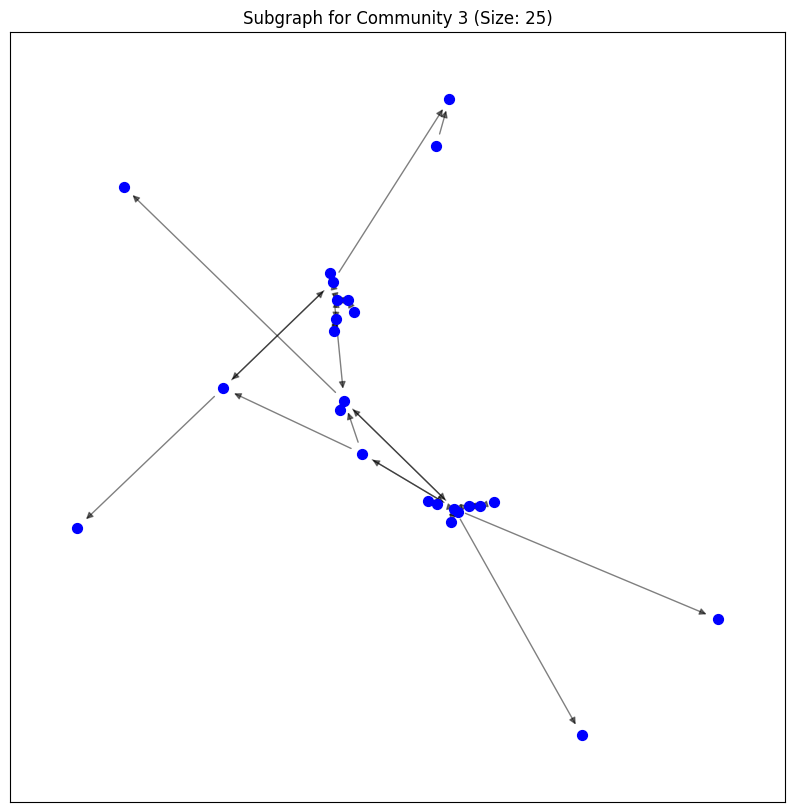

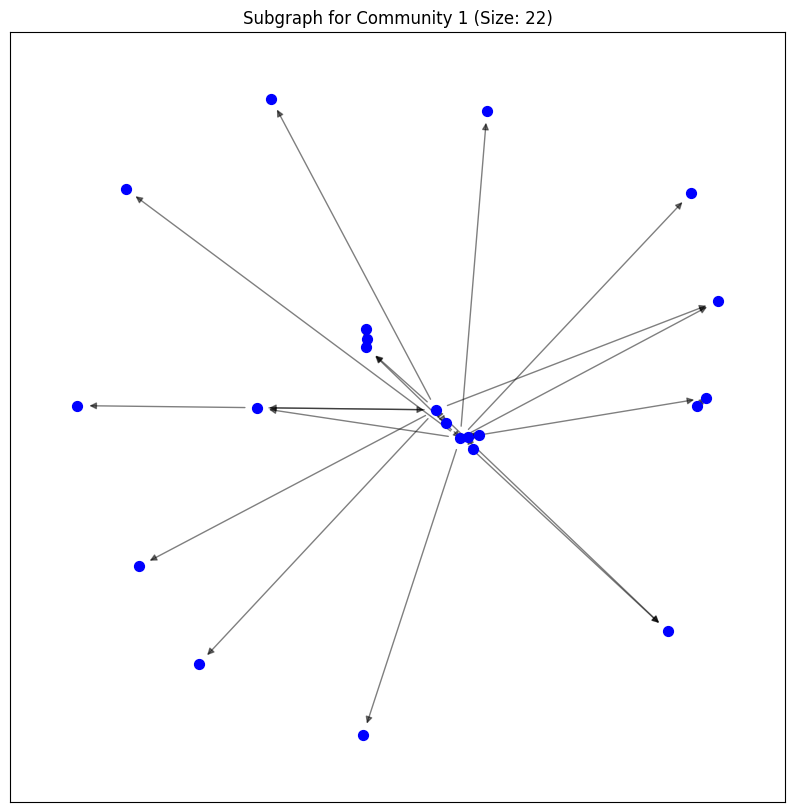

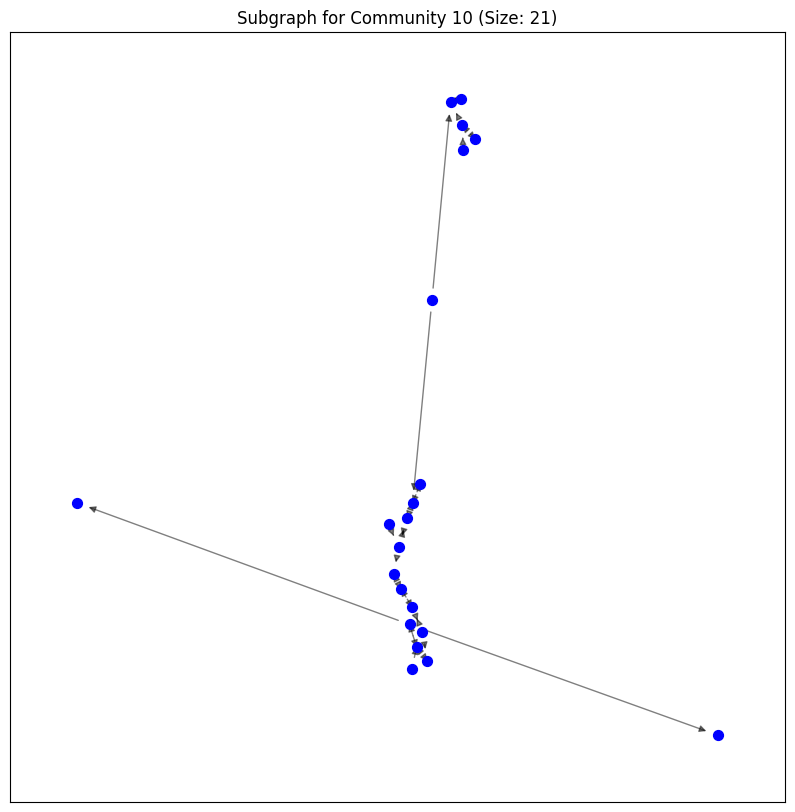

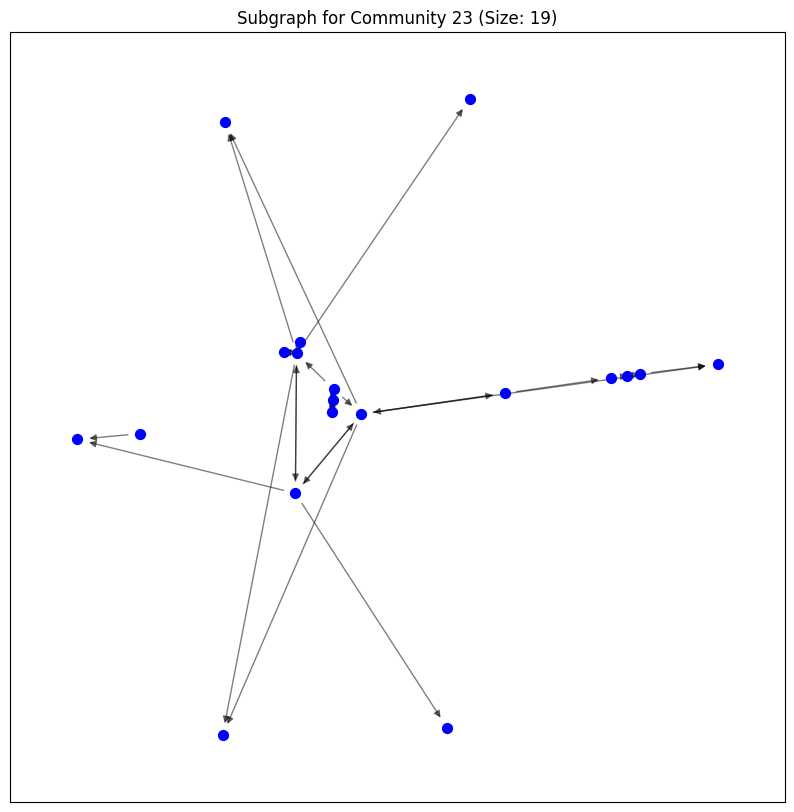

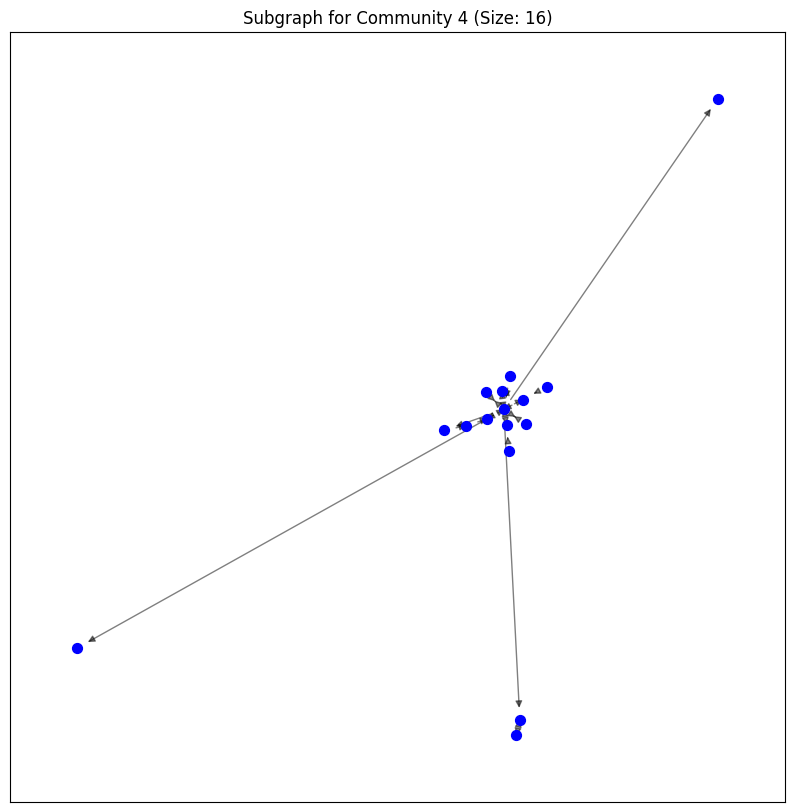

In [28]:
# Visualise the largest communities at the optimal threshold
for community_id, size in community_sizes_optimized.most_common(5):  # Adjust to visualise more or fewer communities
    community_nodes = [node for node, comm in partition_optimized.items() if comm == community_id]
    G_community = G_optimized.subgraph(community_nodes)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G_community, seed=42)  # Layout for better visualisation
    nx.draw_networkx_nodes(G_community, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(G_community, pos, alpha=0.5)
    plt.title(f"Subgraph for Community {community_id} (Size: {size})")
    plt.show()

In [30]:
# Apply the Girvan-Newman algorithm for community detection
communities = girvan_newman(undirected_G)

# Convert the result to a format suitable for modularity calculation
top_level_communities = next(communities)
next_level_communities = next(communities)

# Get the modularity score
modularity_score_girvan_newman = community_louvain.modularity(
    {node: index for index, community in enumerate(next_level_communities) for node in community},
    undirected_G
)
print(f"Modularity Score with Girvan-Newman: {modularity_score_girvan_newman}")


Modularity Score with Girvan-Newman: 0.0011555601756924234


**Temporal Network Analysis**

In [32]:
time_intervals = ['3H', '12H', '24H']  # Hourly, every 3 hours, and every 6 hours

In [34]:
# Create a dictionary to store results for each time interval
graphs_by_interval = {}

for interval in time_intervals:
    graphs_by_interval[interval] = []  # Create an empty list for each interval

    # Group the data by the specified time interval (e.g., '3H' for every 3 hours)
    for time, group in data.groupby(pd.Grouper(key='timestamp', freq=interval)):
        # Create a directed graph for each time window
        G_time_sliced = nx.DiGraph()

        # Add edges from the dataset (sender -> receiver)
        for index, row in group.iterrows():
            G_time_sliced.add_edge(row['sender'], row['receiver'], timestamp=row['timestamp'])

        # Only keep graphs with at least one edge
        if G_time_sliced.number_of_edges() > 0:
            graphs_by_interval[interval].append((time, G_time_sliced))

In [35]:
results = {interval: [] for interval in time_intervals}  # To store community detection results

for interval in time_intervals:
    for time, G_time_sliced in graphs_by_interval[interval]:
        # Convert the directed graph to an undirected graph for community detection
        undirected_G_time_sliced = G_time_sliced.to_undirected()

        # Apply Louvain community detection
        partition = community_louvain.best_partition(undirected_G_time_sliced)

        # Calculate modularity score
        modularity_score = community_louvain.modularity(partition, undirected_G_time_sliced)

        # Store the results
        results[interval].append((time, partition, modularity_score))

In [36]:
# Function to generate a statistical summary for each graph
def graph_statistics(G):
    return {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': sum(dict(G.degree()).values()) / float(G.number_of_nodes()) if G.number_of_nodes() > 0 else 0
    }

# Summary statistics for each time-sliced graph
graph_stats_by_interval = {}

for interval, graph_list in graphs_by_interval.items():
    stats = []
    for time, G_time_sliced in graph_list:
        stats.append({
            'time': time,
            **graph_statistics(G_time_sliced)
        })
    graph_stats_by_interval[interval] = stats

# Display summary statistics for each interval
import pandas as pd

for interval, stats in graph_stats_by_interval.items():
    df_stats = pd.DataFrame(stats)
    print(f"\nStatistics for Interval: {interval}")
    display(df_stats.head(15))  # Show first few records as an example


Statistics for Interval: 3H


,time,num_nodes,num_edges,density,avg_degree
0,2004-04-15 12:00:00,2,1,0.500000,1.000000
1,2004-04-16 21:00:00,2,1,0.500000,1.000000
2,2004-04-19 21:00:00,2,1,0.500000,1.000000
3,2004-04-20 03:00:00,6,4,0.133333,1.333333
4,2004-04-20 06:00:00,15,12,0.057143,1.600000
5,2004-04-20 12:00:00,2,1,0.500000,1.000000
6,2004-04-20 15:00:00,2,1,0.500000,1.000000
7,2004-04-20 18:00:00,2,1,0.500000,1.000000
8,2004-04-20 21:00:00,2,1,0.500000,1.000000
9,2004-04-21 03:00:00,6,4,0.133333,1.333333



Statistics for Interval: 12H


,time,num_nodes,num_edges,density,avg_degree
0,2004-04-15 12:00:00,2,1,0.500000,1.000000
1,2004-04-16 12:00:00,2,1,0.500000,1.000000
2,2004-04-19 12:00:00,2,1,0.500000,1.000000
3,2004-04-20 00:00:00,19,16,0.046784,1.684211
4,2004-04-20 12:00:00,7,4,0.095238,1.142857
5,2004-04-21 00:00:00,16,12,0.050000,1.500000
6,2004-04-21 12:00:00,11,8,0.072727,1.454545
7,2004-04-22 00:00:00,70,103,0.021325,2.942857
8,2004-04-22 12:00:00,52,47,0.017722,1.807692
9,2004-04-23 00:00:00,66,88,0.020513,2.666667



Statistics for Interval: 24H


,time,num_nodes,num_edges,density,avg_degree
0,2004-04-15,2,1,0.500000,1.000000
1,2004-04-16,2,1,0.500000,1.000000
2,2004-04-19,2,1,0.500000,1.000000
3,2004-04-20,24,20,0.036232,1.666667
4,2004-04-21,25,20,0.033333,1.600000
5,2004-04-22,97,147,0.015786,3.030928
6,2004-04-23,87,120,0.016038,2.758621
7,2004-04-24,121,207,0.014256,3.421488
8,2004-04-25,99,150,0.015461,3.030303
9,2004-04-26,127,188,0.011749,2.960630


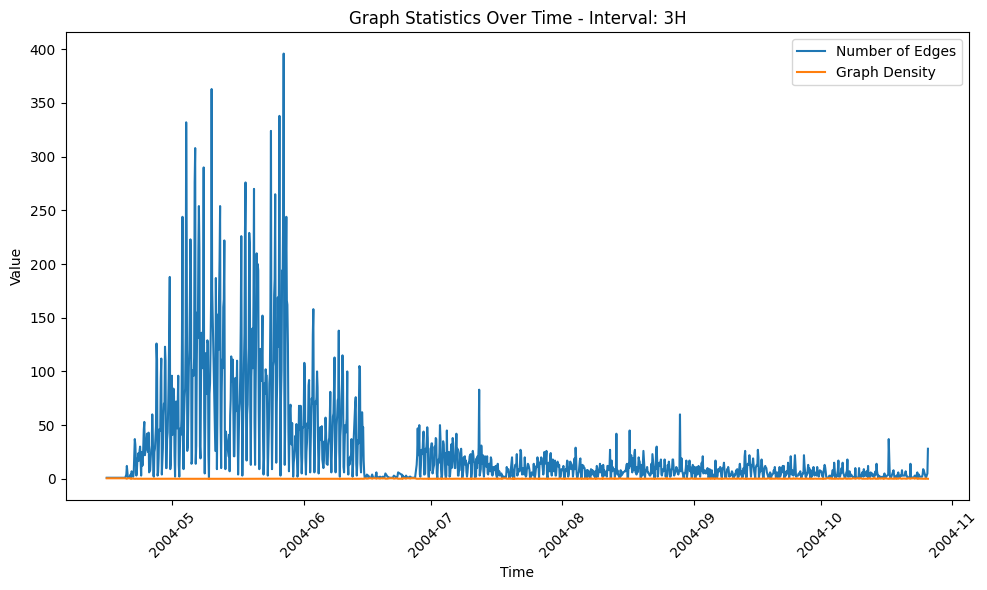

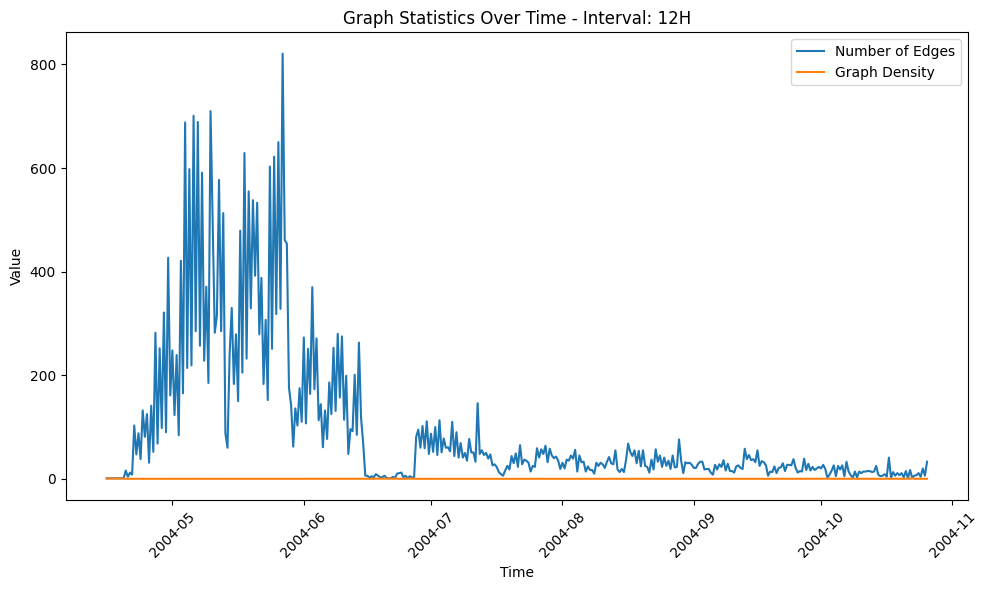

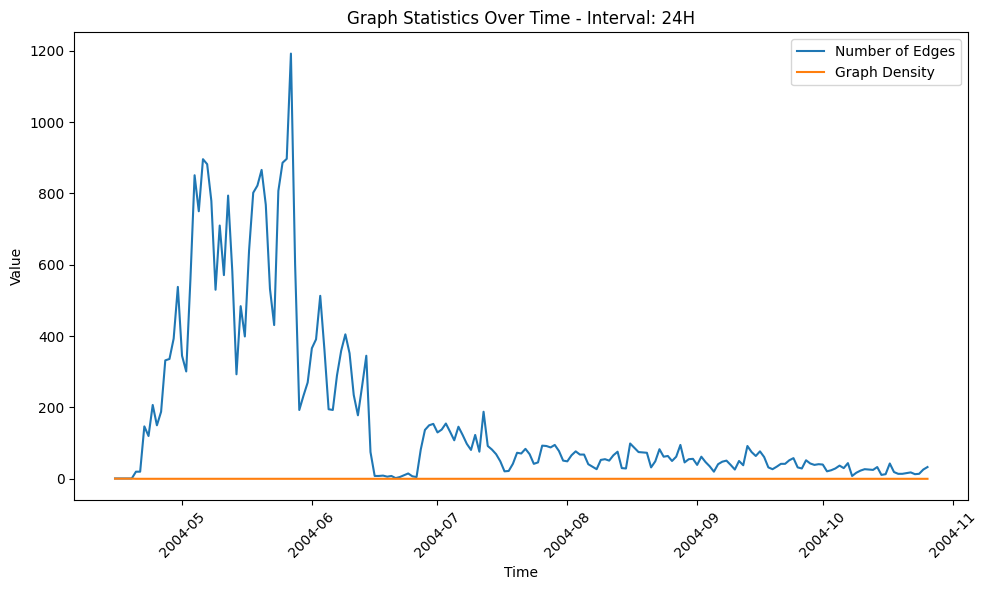

In [37]:

# Example: Plotting the number of edges over time for each interval
for interval, stats in graph_stats_by_interval.items():
    df_stats = pd.DataFrame(stats)

    plt.figure(figsize=(10, 6))
    plt.plot(df_stats['time'], df_stats['num_edges'], label='Number of Edges')
    plt.plot(df_stats['time'], df_stats['density'], label='Graph Density')

    plt.title(f"Graph Statistics Over Time - Interval: {interval}")
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [38]:
# Aggregate statistics across time intervals
aggregated_stats = {}

for interval, stats in graph_stats_by_interval.items():
    df_stats = pd.DataFrame(stats)

    # Compute average statistics across the entire interval
    aggregated_stats[interval] = {
        'avg_num_nodes': df_stats['num_nodes'].mean(),
        'avg_num_edges': df_stats['num_edges'].mean(),
        'avg_density': df_stats['density'].mean(),
        'avg_degree': df_stats['avg_degree'].mean(),
    }

# Display aggregated statistics for each time interval
df_aggregated_stats = pd.DataFrame(aggregated_stats).T
print(df_aggregated_stats)


     avg_num_nodes  avg_num_edges  avg_density  avg_degree
3H       31.485523      29.337788     0.113154    1.462086
12H      77.208995      95.325397     0.043208    1.881439
24H     117.010363     175.430052     0.026912    2.267412


In [39]:
# Example: Identify time windows with significant changes in the number of edges
threshold = 100

for interval, stats in graph_stats_by_interval.items():
    df_stats = pd.DataFrame(stats)

    # Define a threshold for "significant change"
    significant_changes = df_stats[df_stats['num_edges'].diff().abs() > threshold]  # Choose your own threshold

    print(f"\nSignificant Changes for Interval {interval}:")
    display(significant_changes)


Significant Changes for Interval 3H:


,time,num_nodes,num_edges,density,avg_degree
55,2004-04-27 12:00:00,6,3,0.100000,1.000000
63,2004-04-28 12:00:00,7,4,0.095238,1.142857
79,2004-04-30 12:00:00,13,9,0.057692,1.384615
102,2004-05-03 09:00:00,133,244,0.013898,3.669173
103,2004-05-03 12:00:00,37,36,0.027027,1.945946
109,2004-05-04 06:00:00,205,332,0.007939,3.239024
110,2004-05-04 09:00:00,154,222,0.009422,2.883117
111,2004-05-04 12:00:00,26,26,0.040000,2.000000
119,2004-05-05 12:00:00,20,14,0.036842,1.400000
125,2004-05-06 06:00:00,181,276,0.008471,3.049724



Significant Changes for Interval 12H:


,time,num_nodes,num_edges,density,avg_degree
15,2004-04-26 00:00:00,106,141,0.012668,2.660377
17,2004-04-27 00:00:00,140,282,0.014491,4.028571
18,2004-04-27 12:00:00,61,68,0.018579,2.229508
19,2004-04-28 00:00:00,161,252,0.009783,3.130435
20,2004-04-28 12:00:00,91,98,0.011966,2.153846
...,...,...,...,...,...
110,2004-06-13 00:00:00,172,201,0.006834,2.337209
111,2004-06-13 12:00:00,99,85,0.008761,1.717172
112,2004-06-14 00:00:00,189,263,0.007402,2.783069
113,2004-06-14 12:00:00,107,118,0.010404,2.205607



Significant Changes for Interval 24H:


,time,num_nodes,num_edges,density,avg_degree
5,2004-04-22,97,147,0.015786,3.030928
10,2004-04-27,154,332,0.014090,4.311688
13,2004-04-30,256,538,0.008241,4.203125
14,2004-05-01,198,345,0.008845,3.484848
16,2004-05-03,263,558,0.008098,4.243346
17,2004-05-04,333,851,0.007697,5.111111
18,2004-05-05,337,750,0.006624,4.451039
19,2004-05-06,346,896,0.007506,5.179191
21,2004-05-08,423,779,0.004364,3.683215
22,2004-05-09,284,530,0.006594,3.732394


In [41]:
# Create a dictionary to store results for each interval
results = {interval: [] for interval in time_intervals}

for interval in time_intervals:
    print(f"\nAnalyzing communities for interval: {interval}")

    # Group data by the specified time interval
    for time, group in data.groupby(pd.Grouper(key='timestamp', freq=interval)):
        # Create a directed graph for each time window
        G_time_sliced = nx.DiGraph()

        # Add edges to the graph
        for index, row in group.iterrows():
            G_time_sliced.add_edge(row['sender'], row['receiver'], timestamp=row['timestamp'])

        # Convert to an undirected graph for community detection
        undirected_G_time_sliced = G_time_sliced.to_undirected()

        if undirected_G_time_sliced.number_of_edges() > 0:
            # Apply Louvain community detection
            partition_time_sliced = community_louvain.best_partition(undirected_G_time_sliced)

            # Calculate modularity score for the partition
            modularity_score_time_sliced = community_louvain.modularity(partition_time_sliced, undirected_G_time_sliced)
            print(f"Time: {time}, Modularity Score: {modularity_score_time_sliced}")

            # Store the result
            results[interval].append((time, modularity_score_time_sliced, partition_time_sliced))
        else:
            print(f"Time: {time}, No edges in graph.")



Analyzing communities for interval: 3H
Time: 2004-04-15 12:00:00, Modularity Score: 0.0
Time: 2004-04-15 15:00:00, No edges in graph.
Time: 2004-04-15 18:00:00, No edges in graph.
Time: 2004-04-15 21:00:00, No edges in graph.
Time: 2004-04-16 00:00:00, No edges in graph.
Time: 2004-04-16 03:00:00, No edges in graph.
Time: 2004-04-16 06:00:00, No edges in graph.
Time: 2004-04-16 09:00:00, No edges in graph.
Time: 2004-04-16 12:00:00, No edges in graph.
Time: 2004-04-16 15:00:00, No edges in graph.
Time: 2004-04-16 18:00:00, No edges in graph.
Time: 2004-04-16 21:00:00, Modularity Score: 0.0
Time: 2004-04-17 00:00:00, No edges in graph.
Time: 2004-04-17 03:00:00, No edges in graph.
Time: 2004-04-17 06:00:00, No edges in graph.
Time: 2004-04-17 09:00:00, No edges in graph.
Time: 2004-04-17 12:00:00, No edges in graph.
Time: 2004-04-17 15:00:00, No edges in graph.
Time: 2004-04-17 18:00:00, No edges in graph.
Time: 2004-04-17 21:00:00, No edges in graph.
Time: 2004-04-18 00:00:00, No edge

<ipython-input-42-0bfb6d9d8851>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['SmoothedModularity'] = subset['ModularityScore'].rolling(window=larger_window_size).mean()
<ipython-input-42-0bfb6d9d8851>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['SmoothedModularity'] = subset['ModularityScore'].rolling(window=larger_window_size).mean()
<ipython-input-42-0bfb6d9d8851>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

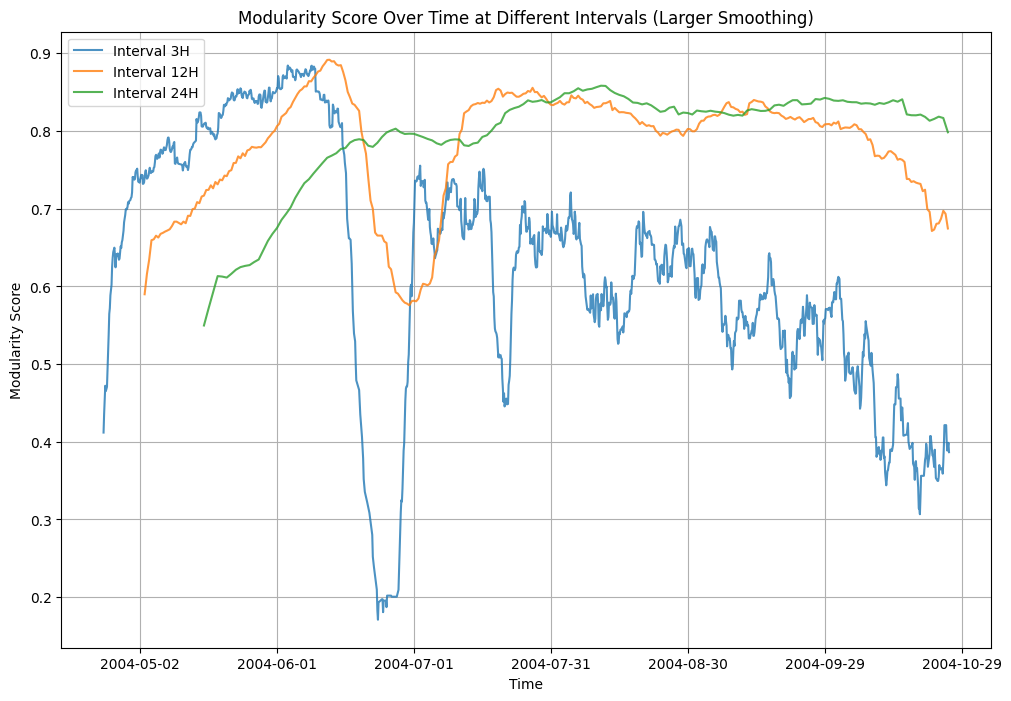

In [42]:
# Increase the figure size
plt.figure(figsize=(12, 8))

# Apply more smoothing with a larger window size
larger_window_size = 30  # You can adjust the window size for more or less smoothing
# Create a DataFrame to store and analyze modularity scores over time
modularity_df = pd.DataFrame(columns=['Interval', 'Time', 'ModularityScore'])

# Create a list to hold DataFrames before concatenating
rows = []

for interval in time_intervals:
    for time, modularity_score, partition in results[interval]:
        # Create a new row as a DataFrame
        new_row = pd.DataFrame({'Interval': [interval], 'Time': [time], 'ModularityScore': [modularity_score]})
        rows.append(new_row)

# Concatenate all rows into the main DataFrame
modularity_df = pd.concat(rows, ignore_index=True)
for interval in time_intervals:
    subset = modularity_df[modularity_df['Interval'] == interval]
    # Apply a larger rolling average to smooth the plot further
    subset['SmoothedModularity'] = subset['ModularityScore'].rolling(window=larger_window_size).mean()
    plt.plot(subset['Time'], subset['SmoothedModularity'], label=f'Interval {interval}', alpha=0.8)

# Reduce the density of x-axis labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(8))  # Show fewer x-axis ticks

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Modularity Score')
plt.title('Modularity Score Over Time at Different Intervals (Larger Smoothing)')

# Add grid for better readability
plt.grid(True)

# Display the legend and show the plot
plt.legend()
plt.show()
